In [1]:
from delphi.log.result_analysis import get_metrics, load_data
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [2]:
run_name = "qwen_cross"
layer = 18

In [3]:
scores_path = Path.cwd() / "results" / run_name / "scores"
latent_df, _ = load_data(scores_path, [f"layers.{layer}"])
latent_df

,text,distance,activating,prediction,probability,correct,activations,latent_idx,score_type,module
0,when it goes down.\nHere is Felix Baumgartner...,-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10005,detection,layers.18
1,"have a very close bond, and it's very enjoyab...",-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10005,detection,layers.18
2,"In addition, the low atmospheric temperatures...",-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10005,detection,layers.18
3,was a most skilful West Coast Māori warrior. ...,-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10005,detection,layers.18
4,generation of Commodore's C64 system. Develop...,4.0,True,False,None,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6484375, 0.0,...",10005,detection,layers.18
...,...,...,...,...,...,...,...,...,...,...
234955,of Food and Agriculture.\nWhat kind of scient...,2.0,True,False,None,False,"[0.0, 1.421875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9999,detection,layers.18
234956,mainly affects the lungs where it is called p...,-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9999,detection,layers.18
234957,help you become a better English speaker.\n© ...,4.0,True,True,None,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9999,detection,layers.18
234958,a cord with their values. They are concerned ...,3.0,True,True,None,True,"[1.3515625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9999,detection,layers.18


In [4]:
processed_df = get_metrics(latent_df)
processed_df

,score_type,true_positives,true_negatives,false_positives,false_negatives,total_examples,total_positives,total_negatives,failed_count,precision,recall,f1_score,accuracy,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,positive_class_ratio,negative_class_ratio,auc
0,detection,50395,86342,26232,62406,225375,112801,112574,0,0.657666,0.44676,0.532076,0.60687,0.44676,0.76698,0.23302,0.55324,0.500504,0.499496,None


In [5]:
def prf(group):
    return pd.Series(
        {
            "precision": precision_score(
                group["activating"],
                group["prediction"],
                zero_division=0,  # or 1, depending on how you want to handle all-zero cases
            ),
            "recall": recall_score(
                group["activating"], group["prediction"], zero_division=0
            ),
            "f1": f1_score(group["activating"], group["prediction"], zero_division=0),
        }
    )

df = latent_df.copy().dropna(subset=["activating", "prediction"])
df.activating = df.activating.astype(int)
df.prediction = df.prediction.astype(int)

metrics_by_pk = (
    df[["activating", "prediction", "latent_idx"]]
    .dropna(subset=["activating", "prediction"], axis=0)
    .groupby("latent_idx")
    .apply(prf)
    .reset_index()
)


/tmp/ipykernel_3215367/2680020173.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(prf)


In [6]:
# show most interpretable latents
metrics_by_pk.sort_values("f1", ascending=False)[:20]

,latent_idx,precision,recall,f1
3483,19168,1.000000,1.000000,1.000000
427,2534,1.000000,1.000000,1.000000
4612,25405,1.000000,0.900000,0.947368
537,3186,1.000000,0.900000,0.947368
4441,24539,1.000000,0.900000,0.947368
5808,32249,1.000000,0.900000,0.947368
264,1581,1.000000,0.900000,0.947368
239,1414,1.000000,0.875000,0.933333
5869,32689,0.904762,0.950000,0.926829
635,3734,0.947368,0.900000,0.923077


In [7]:
pd.set_option("display.max_colwidth", None)
latent_df[latent_df.latent_idx == 4096][["text", "activating"]]

,text,activating


In [8]:
norms = pd.read_csv("norm_strengths.csv")

<Axes: xlabel='relative_norm', ylabel='f1'>

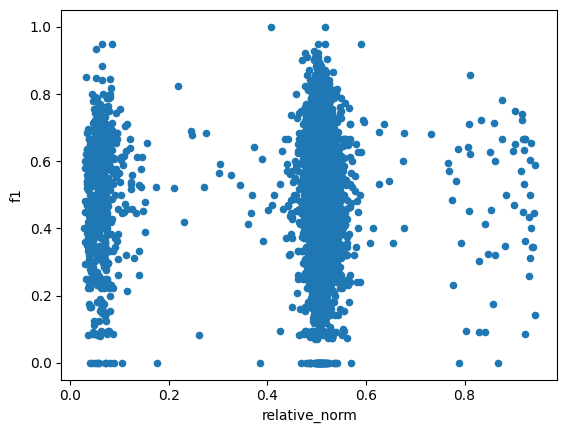

In [9]:
pd.merge(metrics_by_pk, norms, on="latent_idx").plot.scatter(x="relative_norm", y="f1")

In [11]:
m = pd.merge(metrics_by_pk, norms[norms["relative_norm"] < 0.2], on="latent_idx")

In [13]:
m["expl"] = m.latent_idx.progress_map(
    lambda x: open(f"results/qwen_cross/explanations/layers.18_latent{x}.txt").read()
)

100%|██████████| 655/655 [00:01<00:00, 544.45it/s]


In [14]:
m.sort_values("f1", ascending=False)[:20]

,latent_idx,precision,recall,f1,model_a_norm,model_b_norm,relative_norm,expl
54,3186,1.000000,0.900,0.947368,0.778352,0.053676,0.064512,"""Common patterns include idiomatic expressions, comparative adjectives, and specific nouns or phrases related to locations, measurements, and historical or cultural contexts. The text also frequently contains technical or formal language, references to scientific or historical events, and mentions of specific individuals or organizations."""
499,25405,1.000000,0.900,0.947368,0.674342,0.062901,0.085319,"""The text contains various idiomatic expressions, comparative adjectives, and specific terms related to scientific, historical, and cultural contexts. Common patterns include comparative forms ending in \""er,\"" idiomatic phrases, and technical or formal language used in specific fields such as medicine, history, and education."""
23,1414,1.000000,0.875,0.933333,1.872624,0.101449,0.051391,"""The text often provides is often to identify\n analyzing specific\n\nThe text contains dates, delimiters, and specific tokens that are frequently marked, indicating important information such as years, months, and specific events. These tokens often appear in structured formats like dates, references, and numerical values. The patterns suggest that the text is likely from formal documents, reports, or academic papers, where precise dates and references are crucial.\n\nThe tokens marked are primarily numbers, commas, and specific delimiters like years and months, which are used to denote precise temporal information. These patterns are consistent across various contexts, from scientific studies to historical documents."""
121,6290,0.826087,0.950,0.883721,1.928220,0.134084,0.065017,"""Common patterns include proper nouns, abbreviations, and specific terms related to organizations, titles, and historical references. These often appear at the end of sentences or phrases, sometimes preceded by prepositions or articles."""
284,14437,0.850000,0.850,0.850000,2.081907,0.070209,0.032623,"""The text contains frequent occurrences of book titles, article titles, and other works (e.g., poems, acts, symposiums) often introduced by quotation marks or commas, and sometimes followed by publication details or dates."""
201,10329,0.733333,1.000,0.846154,1.806435,0.099457,0.052184,"""The text contains numerical and date references, often at the end of sentences or phrases, and mentions of specific locations, organizations, and legal terms. These elements frequently precede or follow quotation marks or are part of formal or technical language."""
34,2134,0.760000,0.950,0.844444,1.708028,0.149639,0.080552,"""The text contains various technical and scientific terms, often related to measurements, dimensions, and processes in fields such as electronics, biology, physics, and engineering. Common patterns include comparative measurements, technical descriptions, and specific terminologies used in scientific and technical contexts."""
405,21080,0.888889,0.800,0.842105,1.952513,0.135390,0.064845,"""The text contains frequent occurrences of proper nouns, book titles, publishers, and specific institutions, often marked by punctuation and abbreviations. These elements frequently appear in bibliographic references, legal documents, and historical contexts."""
45,2742,0.750000,0.900,0.818182,2.040078,0.183809,0.082652,"""The text contains numerical references and specific tokens (like names, abbreviations, and page numbers) that are often used for citations, references, or to denote particular sections in academic or formal documents. These elements are typically not part of the main content but serve to provide context or direct the reader to specific sources or sections."""
636,31815,0.720000,0.900,0.800000,1.916720,0.169508,0.081251,"""Common patterns include references to specific locations, dates, and general informational content related to health, science, and educational topics."""
